# Proyecto de compañia de seguros Sure Tomorrow.

Necesitamos resolver los siguientes puntos, usando machine learning:
- Tarea 1: encontrar clientes que sean similares a un cliente determinado. Esto ayudará a los agentes de la compañía con el marketing.
- Tarea 2: predecir la probabilidad de que un nuevo cliente reciba una prestación del seguro. ¿Puede un modelo de predictivo funcionar mejor que un modelo dummy?
- Tarea 3: predecir el número de prestaciones de seguro que un nuevo cliente pueda recibir utilizando un modelo de regresión lineal.
- Tarea 4: proteger los datos personales de los clientes sin afectar al modelo del ejercicio anterior. Es necesario desarrollar un algoritmo de transformación de datos que dificulte la recuperación de la información personal si los datos caen en manos equivocadas. Esto se denomina enmascaramiento u ofuscación de datos. Pero los datos deben protegerse de tal manera que no se vea afectada la calidad de los modelos de machine learning. En este caso nos basta con demostrar que el algoritmo funciona correctamente.

# Preprocesamiento y exploración de datos

## Importar las librerías correspondientes

In [1]:
pip install scikit-learn --upgrade --user

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Librerías
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn.linear_model
import math

from sklearn.metrics import mean_squared_error, r2_score, f1_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from IPython.display import display

## Carga de datos

Cargamos los datos y los revisamos para comprobar que no hay problemas con los mismos.

In [3]:
df = pd.read_csv('/datasets/insurance_us.csv')

Observamos los datos del DataFrame, el nombre de las columnas, si hay datos nulos o duplicados.

In [4]:
display(df)

,Gender,Age,Salary,Family members,Insurance benefits
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0
...,...,...,...,...,...
4995,0,28.0,35700.0,2,0
4996,0,34.0,52400.0,1,0
4997,0,20.0,33900.0,2,0
4998,1,22.0,32700.0,3,0


Renombramos las columnas para que el código se vea más coherente con nuestro estilo.

In [5]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


No se observan datos nulos. Los datos de la columna gender están divididos en ceros y unos, por lo que no hay problema con que sean de tipo int. Los datos de las columnas age e income poseen datos de tipo float, aunque hasta ahora parece ser que ambos podrían ser transformados a int. Transformaremos los datos de ambas columnas luego de revisar que no hay problemas al respecto. 

In [7]:
display(df[df['age'].apply(lambda x: np.modf(x)[0] != 0)])

,gender,age,income,family_members,insurance_benefits


In [8]:
display(df[df['income'].apply(lambda x: np.modf(x)[0] != 0)])

,gender,age,income,family_members,insurance_benefits
80,1,41.0,32700.0,0,0
159,1,19.0,64900.0,2,0
313,0,25.0,32700.0,1,0
392,1,43.0,32700.0,1,1
448,1,32.0,32700.0,2,0
772,1,20.0,65100.0,1,0
820,0,29.0,32200.0,2,0
872,0,23.0,32200.0,3,0
911,0,30.0,32200.0,0,0
963,1,20.0,64100.0,0,0


Observamos que no hay números fraccionarios en la columna age pero si en la columna income. Procederemos a hacer la transformación en la columna age a datos de tipo int.

In [9]:
df['age'] = df['age'].astype(int)

In [10]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


None

Todo bien con la transformación de datos. Revisaremos la presencia de datos duplicados a lo largo del DataFrame.

In [11]:
display(df.duplicated().sum())
df=df.drop_duplicates()
display(df.info())

153

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4847 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              4847 non-null   int64  
 1   age                 4847 non-null   int64  
 2   income              4847 non-null   float64
 3   family_members      4847 non-null   int64  
 4   insurance_benefits  4847 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 227.2 KB


None

En el DataFrame original hay alrededor de 153 datos duplicados. Estos fueron removidos. Los análisis y actividades siguientes se harán con dicho DataFrame.

## Análisis exploratorio de datos

Vamos a comprobar rápidamente si existen determinados grupos de clientes observando el gráfico de pares.

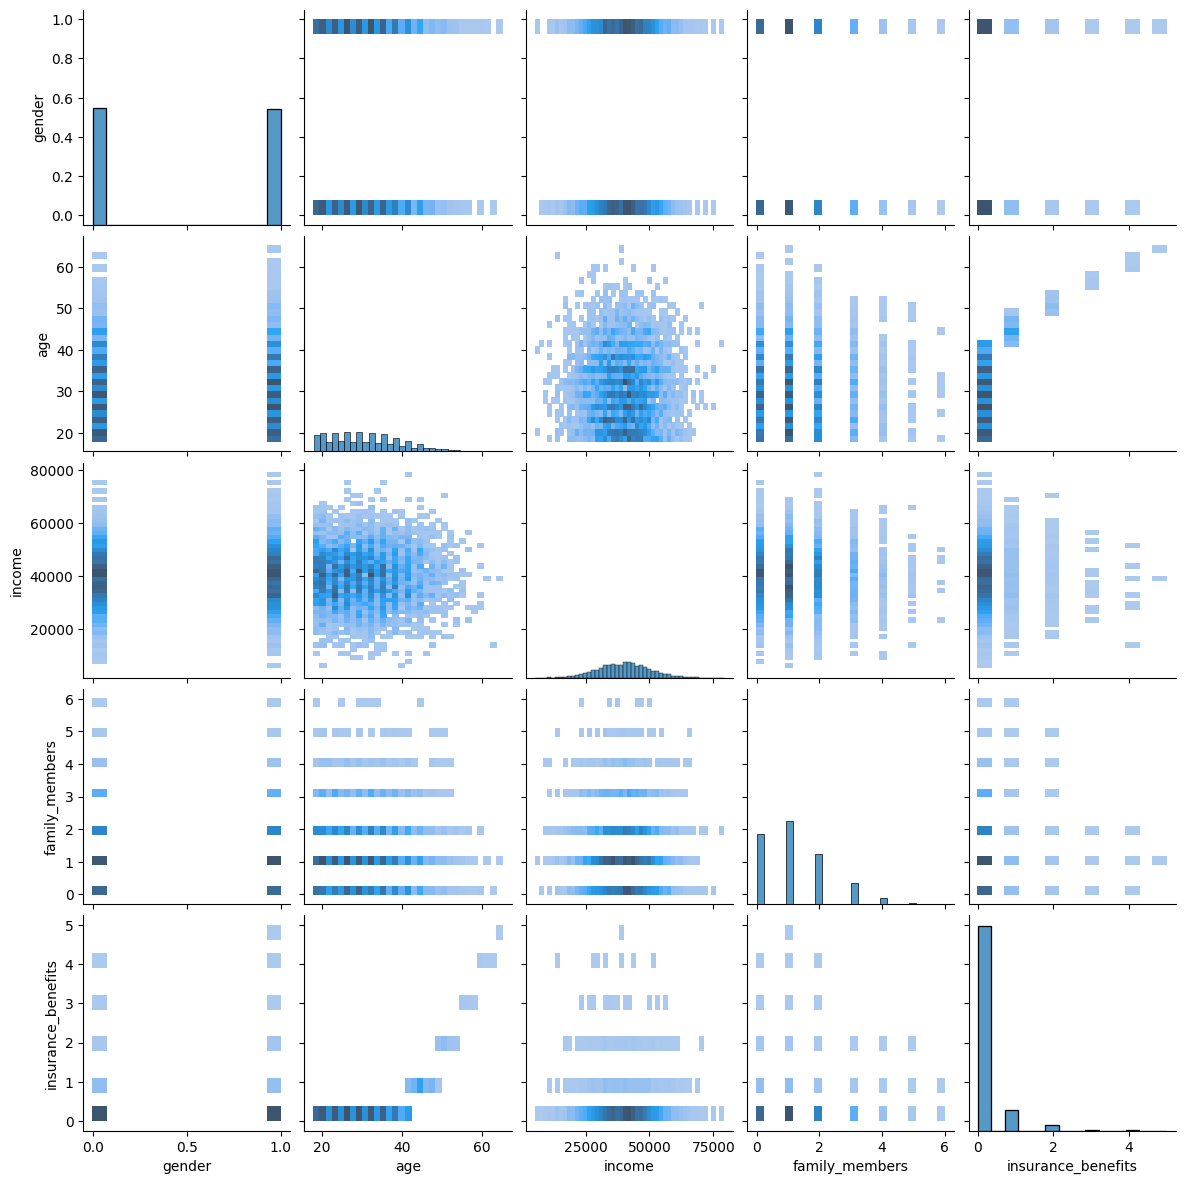

In [12]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Es complicado detectar grupos obvios (clústeres) ya que es difícil combinar diversas variables simultáneamente (para analizar distribuciones multivariadas). Ahí es donde LA y ML nos serán útiles.

# Tarea 1. Clientes similares

Responderemos las siguientes preguntas: ¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?- ¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?

In [13]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [14]:
def get_knn(df, n=5, k=5, metric="euclidean"):
    
    """
    Devuelve los k vecinos más cercanos

    :param df: DataFrame de pandas utilizado para encontrar objetos similares dentro del mismo lugar    
    :param n: número de objetos para los que se buscan los vecinos más cercanos    
    :param k: número de vecinos más cercanos a devolver
    :param métrica: nombre de la métrica de distancia    """

    nbrs = NearestNeighbors(n_neighbors=k, metric=metric).fit(df[feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors(df.loc[[n], feature_names], return_distance=True)    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=df.iloc[nbrs_indices[0]].index, columns=['distance'])
        ], axis=1)
    
    return df_res

Escalamos los datos.

In [15]:
transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()

df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [16]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
744,1.0,0.769231,0.654430,0.166667,2
439,1.0,0.415385,0.522785,0.166667,0
3170,0.0,0.553846,0.683544,0.500000,0
4282,1.0,0.507692,0.497468,0.166667,0
3410,0.0,0.369231,0.429114,0.333333,0


Ahora, vamos a obtener registros similares para uno determinado, para cada combinación

In [17]:
#Datos no escalables, distancia Manhattan
get_knn(df, 5, 5, "cityblock")

,gender,age,income,family_members,insurance_benefits,distance
5,1,43,41000.0,2,1,0.0
3972,1,40,41000.0,1,0,4.0
3801,0,46,41000.0,2,1,4.0
4763,1,46,41000.0,1,1,4.0
1995,0,45,41000.0,0,1,5.0


In [18]:
#Datos escalables, distancia Manhattan
get_knn(df_scaled, 5, 5, "cityblock")

,gender,age,income,family_members,insurance_benefits,distance
5,1.0,0.661538,0.518987,0.333333,1,0.000000
4074,1.0,0.661538,0.501266,0.333333,1,0.017722
1147,1.0,0.646154,0.516456,0.333333,0,0.017916
2962,1.0,0.630769,0.520253,0.333333,0,0.032035
1019,1.0,0.646154,0.501266,0.333333,0,0.033106


In [19]:
#Datos no escalables, distancia Euclidiana
get_knn(df, 5, 5)

,gender,age,income,family_members,insurance_benefits,distance
5,1,43,41000.0,2,1,0.000000
1995,0,45,41000.0,0,1,3.000000
3972,1,40,41000.0,1,0,3.162278
4763,1,46,41000.0,1,1,3.162278
3801,0,46,41000.0,2,1,3.162278


In [20]:
#Datos escalables, distancia Euclidiana
get_knn(df_scaled, 5, 5)

,gender,age,income,family_members,insurance_benefits,distance
5,1.0,0.661538,0.518987,0.333333,1,0.000000
1147,1.0,0.646154,0.516456,0.333333,0,0.015592
4074,1.0,0.661538,0.501266,0.333333,1,0.017722
1019,1.0,0.646154,0.501266,0.333333,0,0.023468
2962,1.0,0.630769,0.520253,0.333333,0,0.030795


**¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?** 

Si. Las caracteristicas (columnas) con datos con magnitudes mayores, tendrán un mayor peso en los resultados obtenidos por el algoritmo (como es el caso de "income" o "age" con respecto a "gender" y "family_members"). Encontramos que no hay diferencias entre los 5 grupos de vecinos obtenidos usando los datos escalados, con respecto a las carecteristicas de "gender" y "family_members". La caracterpistica de "income" no tuvo diferencias entre los grupos cuando los datos no estaban escalados.

**¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?** 

En ambos casos, los resultados del indice 5 se encuentran presente como el primer dato del grupo de vecinos más cercanos, (aunque esto mismo lo observamos tambien con la distancia Euclidiana.) Los primeros tres resultados del número de beneficios de seguro recibidos por una persona asegurada en los últimos cinco años, son los mismos en ambos resultados, aunque hay diferencias entre los indices.

# Tarea 2. ¿Es probable que el cliente reciba una prestación del seguro?

En términos de machine learning podemos considerarlo como una tarea de clasificación binaria.

Con el valor de `insurance_benefits` superior a cero como objetivo, evaluaremos si el enfoque de clasificación kNN puede funcionar mejor que el modelo dummy.

Dividiremos todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30.

In [21]:
# Calcular el objetivo
df['insurance_benefits_received'] = (df['insurance_benefits'] > 0).astype(int)
display(df)

,gender,age,income,family_members,insurance_benefits,insurance_benefits_received
0,1,41,49600.0,1,0,0
1,0,46,38000.0,1,1,1
2,0,29,21000.0,0,0,0
3,0,21,41700.0,2,0,0
4,1,28,26100.0,0,0,0
...,...,...,...,...,...,...
4995,0,28,35700.0,2,0,0
4996,0,34,52400.0,1,0,0
4997,0,20,33900.0,2,0,0
4998,1,22,32700.0,3,0,0


In [22]:
# Comprobar el desequilibrio de clases con value_counts()

display(df['insurance_benefits_received'].value_counts())

0    4284
1     563
Name: insurance_benefits_received, dtype: int64

En la columna "insurance_benefits_received" tenemos 4284 clientes sin beneficios y 563 con algún beneficio del seguro.

In [23]:
# Generar una funcion para evaluar el modelo de clasificación 
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    display(f'F1: {f1_score:.2f}')
    
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')

    display('Matriz de confusión')
    display(cm)

In [24]:
# Generar una funcion de un modelo aleatorio

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [25]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    display(f'La probabilidad: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, size=len(df))
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)

'La probabilidad: 0.00'

'F1: 0.00'

'Matriz de confusión'

array([[0.88384568, 0.        ],
       [0.11615432, 0.        ]])

'La probabilidad: 0.12'

'F1: 0.13'

'Matriz de confusión'

array([[0.78502166, 0.09882401],
       [0.1017124 , 0.01444192]])

'La probabilidad: 0.50'

'F1: 0.19'

'Matriz de confusión'

array([[0.44873117, 0.4351145 ],
       [0.05921188, 0.05694244]])

'La probabilidad: 1.00'

'F1: 0.21'

'Matriz de confusión'

array([[0.        , 0.88384568],
       [0.        , 0.11615432]])

El valor de F1 va en aumento conforme la probabilidad. Cuando la probabilidad es 0, unicamente tenemos los datos de falsos y verdaderos negativos. Conforme aumentamos la probabilidad, los valores de falsos y veraderos positivos se incrementan. En el modelo aleatorio el valor de F1 va desde 0 a 0.21.

In [26]:
# Preparar los datos
features = df.drop(columns=['insurance_benefits'])  # Variables independientes
target = df['insurance_benefits_received']  # Objetivo 

# Dividir los datos en entrenamiento y prueba (70:30)
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Escalar los datos
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train)
features_test_scaled = scaler.transform(features_test)

In [27]:
# Construcción del modelo KNN y evaluación
f1_scores_original = []
f1_scores_scaled = []

for k in range(1, 11):
    # Modelo KNN para datos originales
    knn_original = KNeighborsClassifier(n_neighbors=k)
    knn_original.fit(features_train, target_train)
    y_pred_original = knn_original.predict(features_test)
    f1_scores_original.append(f1_score(target_test, y_pred_original))

    # Modelo KNN para datos escalados
    knn_scaled = KNeighborsClassifier(n_neighbors=k)
    knn_scaled.fit(features_train_scaled, target_train)
    y_pred_scaled = knn_scaled.predict(features_test_scaled)
    f1_scores_scaled.append(f1_score(target_test, y_pred_scaled))

In [28]:
# Resultados
display("F1 Scores para KNN (datos originales):", f1_scores_original)
display("F1 Scores para KNN (datos escalados):", f1_scores_scaled)

'F1 Scores para KNN (datos originales):'

[0.6643598615916955,
 0.46788990825688076,
 0.4576271186440678,
 0.16,
 0.16666666666666666,
 0.08433734939759036,
 0.10714285714285714,
 0.025,
 0.037267080745341616,
 0.025]

'F1 Scores para KNN (datos escalados):'

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Con los datos no escalados, con un menor número de vecinos el valor de F1 es más cercana a 1 y por lo tanto la media armónica entre la presición y sensibilidad es más optima. En el caso de los datos escalados, observamos que no importó el número de vecinos usados, los valores de F1 siempre fueron lo más óptimos posibles. Podemos inferir que nuestro clasificador basado en KNN (de los vecinos más cercanos) es útil aún cuando se usan los datos no escalados, comparandolo con los obtenidos con el clasificador aleatorio.

# Tarea 3. Regresión (con regresión lineal)

Con `insurance_benefits` como objetivo, evaluaremos cuál sería la RECM de un modelo de regresión lineal. Comprobaremos la RECM para los datos originales y los escalados. Dividiremos todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30.

In [29]:
# Clase de regresión lineal personalizada
class MyLinearRegression:
    def __init__(self):
        self.weights = None
    
    def fit(self, X, y):
        # Añadir las unidades (columna de unos)
        X2 = np.hstack([np.ones((X.shape[0], 1)), X])
        self.weights = np.linalg.inv(X2.T @ X2) @ X2.T @ y

    def predict(self, X):
        # Añadir las unidades (columna de unos)
        X2 = np.hstack([np.ones((X.shape[0], 1)), X])
        return X2 @ self.weights

In [30]:
# Función para evaluar el modelo
def eval_regressor(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred)  # Calcula directamente la raíz cuadrada
    print(f"RMSE: {rmse:.2f}")
    r2 = r2_score(y_true, y_pred)  # R2 sin raíz cuadrada
    print(f"R2: {r2:.2f}")

In [31]:
# Separar características (X) y objetivo (y)
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

# Dividir los datos en entrenamiento y prueba (70:30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

# Crear el modelo
lr = MyLinearRegression()

# Ajustar el modelo (entrenamiento no escalado)
lr.fit(X_train, y_train)

# Hacer predicciones (datos no escalados)
print("Datos originales:")
y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

Datos originales:
RMSE: 0.13
R2: 0.43


In [32]:
# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ajustar el modelo (entrenamiento escalado)
lr.fit(X_train_scaled, y_train)

# Predicciones (datos escalados)
print("Datos escalados:")
y_test_pred_scaled = lr.predict(X_test_scaled)
eval_regressor(y_test, y_test_pred_scaled)

Datos escalados:
RMSE: 0.13
R2: 0.43


En ambos casos observamos que tanto los datos escalados como no escalados tienen el mismo valor de RMSE y R2.

# Tarea 4. Ofuscar datos

Podemos ofuscar los datos multiplicando las características numéricas por una matriz invertible $P$. 

$$
X' = X \times P
$$

In [33]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [34]:
X = df_pn.to_numpy()

Generamos una matriz aleatoria $P$.

In [35]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Comprobamos que la matriz P sea invertible

In [36]:
# Asegurarse de que P es invertible
while np.linalg.det(P) == 0:
    P = np.random(size=(X.shape[1], X.shape[1]))

# Transformar los datos
data_transformed = np.dot(X, P)

# Convertir de nuevo a DataFrame para inspeccionar
df_transformed = pd.DataFrame(data_transformed, columns=feature_names)

# Imprimir originales y transformados
display("Datos originales:")
display(df.head())
display("Datos transformados:")
display(df_transformed.head())

'Datos originales:'

,gender,age,income,family_members,insurance_benefits,insurance_benefits_received
0,1,41,49600.0,1,0,0
1,0,46,38000.0,1,1,1
2,0,29,21000.0,0,0,0
3,0,21,41700.0,2,0,0
4,1,28,26100.0,0,0,0


'Datos transformados:'

,gender,age,income,family_members
0,6359.715273,22380.404676,18424.090742,46000.696690
1,4873.294065,17160.367030,14125.780761,35253.455773
2,2693.117429,9486.397744,7808.831560,19484.860631
3,5345.603937,18803.227203,15479.148373,38663.061863
4,3347.176735,11782.829283,9699.998942,24211.273378


¿Podemos adivinar la edad o los ingresos de los clientes después de la transformación?

No es posible adivinar los datos de los clientes. Gracias al nombre de las columnas inferimos el tipo de datos.

¿Podemos recuperar los datos originales de $X'$ si conoces $P$?

In [37]:
# Calcular la inversa de la matriz invertible (P)
P_inv= np.linalg.inv(P)

#Multiplicar por los datos transformados por la inversa de P
ori= np.dot(data_transformed, P_inv)

# Convertir de nuevo a DataFrame para inspeccionar
df_reco=pd.DataFrame(ori, columns=feature_names)

# Imprimir datos originalese y recuperados
display("Datos originales:")
display(df.head())
display("Datos recuperados:")
display(df_reco.head())

'Datos originales:'

,gender,age,income,family_members,insurance_benefits,insurance_benefits_received
0,1,41,49600.0,1,0,0
1,0,46,38000.0,1,1,1
2,0,29,21000.0,0,0,0
3,0,21,41700.0,2,0,0
4,1,28,26100.0,0,0,0


'Datos recuperados:'

,gender,age,income,family_members
0,1.000000e+00,41.0,49600.0,1.000000e+00
1,-4.473636e-12,46.0,38000.0,1.000000e+00
2,-2.515869e-12,29.0,21000.0,9.524523e-13
3,-4.844982e-12,21.0,41700.0,2.000000e+00
4,1.000000e+00,28.0,26100.0,-1.019907e-13


Muestra los tres casos para algunos clientes- Datos originales
- El que está transformado- El que está invertido (recuperado)

In [38]:
# Imprimir los datos originales, transformados y recuperados
display("Datos originales:")
display(df.head())
display("Datos transformados:")
display(df_transformed.head())
display("Datos recuperados:")
display(df_reco.head())

'Datos originales:'

,gender,age,income,family_members,insurance_benefits,insurance_benefits_received
0,1,41,49600.0,1,0,0
1,0,46,38000.0,1,1,1
2,0,29,21000.0,0,0,0
3,0,21,41700.0,2,0,0
4,1,28,26100.0,0,0,0


'Datos transformados:'

,gender,age,income,family_members
0,6359.715273,22380.404676,18424.090742,46000.696690
1,4873.294065,17160.367030,14125.780761,35253.455773
2,2693.117429,9486.397744,7808.831560,19484.860631
3,5345.603937,18803.227203,15479.148373,38663.061863
4,3347.176735,11782.829283,9699.998942,24211.273378


'Datos recuperados:'

,gender,age,income,family_members
0,1.000000e+00,41.0,49600.0,1.000000e+00
1,-4.473636e-12,46.0,38000.0,1.000000e+00
2,-2.515869e-12,29.0,21000.0,9.524523e-13
3,-4.844982e-12,21.0,41700.0,2.000000e+00
4,1.000000e+00,28.0,26100.0,-1.019907e-13


Podemos ver que algunos valores no son exactamente iguales a los de los datos originales. 
Las computadoras trabajan con una precisión finita. Los números muy pequeños (o muy grandes) no pueden ser representados exactamente. Al hacer varias acciones (generar matrices aleatorias,  calcular la inversa de una matriz, entre otros) se generan pequeños errores de redondeo que pueden acumularse, resultando en valores muy cercanos a cero.

## Prueba de que la ofuscación de datos puede funcionar con regresión lineal

En este proyecto la tarea de regresión se ha resuelto con la regresión lineal.

Entonces, los datos están ofuscados y ahora tenemos $X \times P$ en lugar de tener solo $X$. En consecuencia, hay otros pesos $w_P$ como
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

**PREGUNTAS**

¿Cómo se relacionarían $w$ y $w_P$ si simplificáramos la fórmula de $w_P$ anterior? 

¿Cuáles serían los valores predichos con $w_P$? 

¿Qué significa esto para la calidad de la regresión lineal si esta se mide mediante la RECM?
Revisa el Apéndice B Propiedades de las matrices al final del cuaderno. ¡Allí encontrarás fórmulas muy útiles!

No es necesario escribir código en esta sección, basta con una explicación analítica.

**RESPUESTAS**

1.- Al simplificar la primera fórmula de $w_P$, al usar las propiedades de matrices invertibles, y que notando que 
$(P^T)^{−1}(P^T)$ se cancela (ya que se convierte en $1$), tenemos la siguiente fórmula:
$$
w_P= P^{−1}(X^TX)^{−1}(X^T)y
$$

Como está mostrado en el inciso que $w = (X^T X)^{-1} X^Ty$, podemos sustituir $w$ en nuestra fórmula:

$$
w_P= P^{−1}w
$$

$W_P$ se obtiene transformando $w$ mediante la matriz inversa $P^{−1}$ Esto indica que 
$W_P$ es simplemente una reescalada de $w$ en el espacio de las características transformadas.

2.- Los valores predichos de $w_p$ serían los mismos por $w$ la transformación por P solo cambia el espacio de las características, no las predicciones. 

3.-El RECM no cambia después de la transformación de las características. Los valores predichos en regresión lineal se calculan como $y^=Xw$. Como los valores de predichos son identicos, la calidad de la regresión lineal es la misma antes y después de la ofuscación.

## Prueba de regresión lineal con ofuscación de datos

Probaremos que la regresión lineal pueda funcionar, en términos computacionales, con la transformación de ofuscación elegida.

**Procedimiento**

- Crearemos una matriz cuadrada $P$ de números aleatorios.- Comprobaremos que sea invertible.
- Utilizaremos $XP$ como la nueva matriz de características

In [39]:
# Clase de regresión lineal
class MyLinearRegressionobfs:
    def __init__(self):
        self.weights = None
        self.P = None  # Matriz de ofuscamiento

    def fit(self, X, y, obfuscate=False):
        # Ofuscar datos si es necesario
        if obfuscate:
            self.P = self._generate_invertible_matrix(X.shape[1])
            X = X @ self.P

        # Añadir las unidades (columna de unos)
        X2 = np.hstack([np.ones((X.shape[0], 1)), X])
        self.weights = np.linalg.inv(X2.T @ X2) @ X2.T @ y

    def predict(self, X):
        # Ofuscar datos si la matriz P fue utilizada en el entrenamiento
        if self.P is not None:
            X = X @ self.P

        # Añadir las unidades (columna de unos)
        X2 = np.hstack([np.ones((X.shape[0], 1)), X])
        return X2 @ self.weights

    def _generate_invertible_matrix(self, size):
        """
        Genera una matriz aleatoria invertible.
        """
        np.random.seed(42)  # Fijar semilla para reproducibilidad
        P = np.random.rand(size, size)
        while np.linalg.det(P) == 0:
            P = np.random.rand(size, size)
        return P

In [40]:
# Separar características (X) y objetivo (y)
features = df[['age', 'gender', 'income', 'family_members']].to_numpy()
target = df['insurance_benefits'].to_numpy()

# Dividir los datos en entrenamiento y prueba (70:30)
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=12345)

# Crear el modelo
lr = MyLinearRegressionobfs() #No  ofuscado
lr_obf = MyLinearRegressionobfs() #Ofuscado

# Escalar los datos
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train)
features_test_scaled = scaler.transform(features_test)

# Ajustar el modelo (entrenamiento no ofuscado)
lr.fit(features_train_scaled, target_train)

# Ajustar el modelo (entrenamiento ofuscado)
lr_obf.fit(features_train_scaled, target_train, obfuscate=True)

# Predicciones (datos ofuscados)
print("Datos ofuscados:")
target_test_pred_scaled = lr.predict(features_test_scaled)
eval_regressor(target_test, target_test_pred_scaled)

# Predicciones (datos originales)
print("Datos originales:")
target_test_pred_scaled = lr_obf.predict(features_test_scaled)
eval_regressor(target_test, target_test_pred_scaled)

Datos ofuscados:
RMSE: 0.13
R2: 0.43
Datos originales:
RMSE: 0.13
R2: 0.43


Los resultados del RMSE y R2 no cambian entre la regresión lineal usando los datos ofuscados y donde se usan los datos originales. 

# Conclusiones

Escribimos la funcion que devuelve los "k" vecinos más cercanos a un objeto basandonos en metricas de distancia especificas. Usamos dicha función para hacer un modelo de clasificación KNN que tiene niveles optimos en términos de sensibilidad y presición con respecto a si los clientes poseen beneficios del seguro. 

Hicimos un modelo de regresión lineal con el cual se pueden ofuscar los datos a través de matrices invertibles. Corroboramos con métricas como el RMSE que dicho ofuscamiento no afectaba a los resultados del entrenamiento por parte de nuestro modelo.